In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

# Define custom dataset for paired images
class PairedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_pairs = self.load_image_pairs()

    def load_image_pairs(self):
        pairs = []
        for filename in os.listdir(self.root_dir):
            if "_A" in filename:
                input_img = os.path.join(self.root_dir, filename)
                target_img = os.path.join(self.root_dir, filename.replace("_A", "_B"))
                pairs.append((input_img, target_img))
        return pairs

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        input_img_path, target_img_path = self.image_pairs[idx]
        input_img = Image.open(input_img_path).convert('L')  # Convert to grayscale
        target_img = Image.open(target_img_path).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)

        return input_img, target_img

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # For grayscale image
])

# Load dataset
train_dataset = PairedDataset(root_dir='/media/Data', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Define the U-Net generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                      nn.BatchNorm2d(out_channels),
                      nn.ReLU(inplace=True)]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        self.down1 = down_block(in_channels, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, normalize=False)

        self.up1 = up_block(512, 512, dropout=0.5)
        self.up2 = up_block(1024, 512, dropout=0.5)
        self.up3 = up_block(1024, 512, dropout=0.5)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return u8

# Define the PatchGAN discriminator
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchGANDiscriminator, self).__init__()

        def block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(in_channels +1, 64, normalize=False),
            block(64, 128),
            block(128, 256),
            block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)

# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    for i, (input_img, target_img) in enumerate(tqdm(train_dataloader)):
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_output = discriminator(target_img, input_img)
        fake_img = generator(input_img).detach()
        fake_output = discriminator(fake_img, input_img)
        d_loss_real = adversarial_loss(real_output, torch.ones_like(real_output))
        d_loss_fake = adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_img = generator(input_img)
        fake_output = discriminator(fake_img, input_img)
        g_adv_loss = adversarial_loss(fake_output, torch.ones_like(fake_output))
        g_l1_loss = l1_loss(fake_img, target_img)
        g_loss = g_adv_loss + 100 * g_l1_loss
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_dataloader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    # Save model checkpoints
torch.save(generator.state_dict(), 'generator_epoch.pth')
torch.save(discriminator.state_dict(), 'discriminator_epoch.pth')


 50%|█████     | 2/4 [00:00<00:00,  2.85it/s]

Epoch [0/100], Step [0/4], D Loss: 0.7168319821357727, G Loss: 61.52000427246094


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [1/100], Step [0/4], D Loss: 0.6514286398887634, G Loss: 40.60495376586914


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [2/100], Step [0/4], D Loss: 0.5896806716918945, G Loss: 28.60555076599121


 50%|█████     | 2/4 [00:01<00:00,  2.12it/s]

Epoch [3/100], Step [0/4], D Loss: 0.5079562664031982, G Loss: 25.643226623535156


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [4/100], Step [0/4], D Loss: 0.4566207826137543, G Loss: 23.619747161865234


 50%|█████     | 2/4 [00:01<00:00,  2.13it/s]

Epoch [5/100], Step [0/4], D Loss: 0.31298118829727173, G Loss: 20.780941009521484


 50%|█████     | 2/4 [00:01<00:00,  2.18it/s]

Epoch [6/100], Step [0/4], D Loss: 0.1974387764930725, G Loss: 19.991954803466797


 50%|█████     | 2/4 [00:01<00:00,  2.16it/s]

Epoch [7/100], Step [0/4], D Loss: 0.10105310380458832, G Loss: 21.875328063964844


 50%|█████     | 2/4 [00:01<00:00,  2.17it/s]

Epoch [8/100], Step [0/4], D Loss: 0.13975222408771515, G Loss: 19.889493942260742


 50%|█████     | 2/4 [00:01<00:00,  2.05it/s]

Epoch [9/100], Step [0/4], D Loss: 0.2260323017835617, G Loss: 19.57994842529297


 50%|█████     | 2/4 [00:01<00:00,  2.04it/s]

Epoch [10/100], Step [0/4], D Loss: 0.10451537370681763, G Loss: 18.97625732421875


 50%|█████     | 2/4 [00:01<00:00,  2.15it/s]

Epoch [11/100], Step [0/4], D Loss: 0.4659281075000763, G Loss: 15.544818878173828


 50%|█████     | 2/4 [00:01<00:00,  2.15it/s]

Epoch [12/100], Step [0/4], D Loss: 0.6371681690216064, G Loss: 14.996053695678711


 50%|█████     | 2/4 [00:01<00:00,  2.16it/s]

Epoch [13/100], Step [0/4], D Loss: 0.5386660695075989, G Loss: 13.669990539550781


 50%|█████     | 2/4 [00:01<00:00,  2.14it/s]

Epoch [14/100], Step [0/4], D Loss: 0.4742908775806427, G Loss: 14.936964988708496


 50%|█████     | 2/4 [00:01<00:00,  2.06it/s]

Epoch [15/100], Step [0/4], D Loss: 0.613711953163147, G Loss: 15.749515533447266


 50%|█████     | 2/4 [00:01<00:00,  2.10it/s]

Epoch [16/100], Step [0/4], D Loss: 0.4946857690811157, G Loss: 14.376055717468262


 50%|█████     | 2/4 [00:01<00:00,  2.19it/s]

Epoch [17/100], Step [0/4], D Loss: 0.47605279088020325, G Loss: 14.862665176391602


 50%|█████     | 2/4 [00:01<00:00,  2.17it/s]

Epoch [18/100], Step [0/4], D Loss: 0.7305890917778015, G Loss: 15.012784004211426


 50%|█████     | 2/4 [00:01<00:00,  2.18it/s]

Epoch [19/100], Step [0/4], D Loss: 0.5933026671409607, G Loss: 13.286876678466797


 50%|█████     | 2/4 [00:01<00:00,  2.18it/s]

Epoch [20/100], Step [0/4], D Loss: 0.5379671454429626, G Loss: 14.10019302368164


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [21/100], Step [0/4], D Loss: 0.674489438533783, G Loss: 13.519354820251465


 50%|█████     | 2/4 [00:01<00:00,  2.12it/s]

Epoch [22/100], Step [0/4], D Loss: 0.43894946575164795, G Loss: 14.017303466796875


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [23/100], Step [0/4], D Loss: 0.5195896625518799, G Loss: 15.203442573547363


 50%|█████     | 2/4 [00:01<00:00,  2.19it/s]

Epoch [24/100], Step [0/4], D Loss: 0.5247271656990051, G Loss: 12.703487396240234


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [25/100], Step [0/4], D Loss: 0.4668389558792114, G Loss: 13.377779006958008


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [26/100], Step [0/4], D Loss: 0.4966334104537964, G Loss: 14.14628791809082


 50%|█████     | 2/4 [00:01<00:00,  2.25it/s]

Epoch [27/100], Step [0/4], D Loss: 0.5004871487617493, G Loss: 12.175934791564941


 50%|█████     | 2/4 [00:01<00:00,  2.15it/s]

Epoch [28/100], Step [0/4], D Loss: 0.39506250619888306, G Loss: 12.287007331848145


 50%|█████     | 2/4 [00:01<00:00,  2.12it/s]

Epoch [29/100], Step [0/4], D Loss: 0.5042444467544556, G Loss: 13.914356231689453


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [30/100], Step [0/4], D Loss: 0.5446611046791077, G Loss: 15.701761245727539


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [31/100], Step [0/4], D Loss: 0.4699719250202179, G Loss: 13.97541618347168


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [32/100], Step [0/4], D Loss: 0.4412606954574585, G Loss: 13.653425216674805


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [33/100], Step [0/4], D Loss: 0.42500799894332886, G Loss: 11.885600090026855


 50%|█████     | 2/4 [00:01<00:00,  2.25it/s]

Epoch [34/100], Step [0/4], D Loss: 0.4327136278152466, G Loss: 12.910478591918945


 50%|█████     | 2/4 [00:01<00:00,  2.12it/s]

Epoch [35/100], Step [0/4], D Loss: 0.5686600208282471, G Loss: 13.100900650024414


 50%|█████     | 2/4 [00:01<00:00,  2.26it/s]

Epoch [36/100], Step [0/4], D Loss: 0.606815755367279, G Loss: 12.616167068481445


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [37/100], Step [0/4], D Loss: 0.6093815565109253, G Loss: 11.758995056152344


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [38/100], Step [0/4], D Loss: 0.5636751651763916, G Loss: 11.418676376342773


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [39/100], Step [0/4], D Loss: 0.459868460893631, G Loss: 12.60897159576416


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [40/100], Step [0/4], D Loss: 0.6367059350013733, G Loss: 12.55362319946289


 50%|█████     | 2/4 [00:01<00:00,  2.12it/s]

Epoch [41/100], Step [0/4], D Loss: 0.4608410894870758, G Loss: 11.753793716430664


 50%|█████     | 2/4 [00:01<00:00,  2.13it/s]

Epoch [42/100], Step [0/4], D Loss: 0.7759883999824524, G Loss: 13.065912246704102


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [43/100], Step [0/4], D Loss: 0.5557868480682373, G Loss: 11.018268585205078


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [44/100], Step [0/4], D Loss: 0.6462258100509644, G Loss: 11.590686798095703


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [45/100], Step [0/4], D Loss: 0.45285093784332275, G Loss: 12.984731674194336


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [46/100], Step [0/4], D Loss: 0.5234183073043823, G Loss: 12.508922576904297


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [47/100], Step [0/4], D Loss: 0.6331840753555298, G Loss: 12.456502914428711


 50%|█████     | 2/4 [00:01<00:00,  2.10it/s]

Epoch [48/100], Step [0/4], D Loss: 0.6490695476531982, G Loss: 10.375506401062012


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [49/100], Step [0/4], D Loss: 0.46560654044151306, G Loss: 11.179306983947754


 50%|█████     | 2/4 [00:01<00:00,  2.20it/s]

Epoch [50/100], Step [0/4], D Loss: 0.5480721592903137, G Loss: 11.075355529785156


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [51/100], Step [0/4], D Loss: 0.6528415679931641, G Loss: 11.398855209350586


 50%|█████     | 2/4 [00:01<00:00,  2.20it/s]

Epoch [52/100], Step [0/4], D Loss: 0.5320944786071777, G Loss: 11.178829193115234


 50%|█████     | 2/4 [00:01<00:00,  2.20it/s]

Epoch [53/100], Step [0/4], D Loss: 0.5285828709602356, G Loss: 10.89852523803711


 50%|█████     | 2/4 [00:01<00:00,  2.10it/s]

Epoch [54/100], Step [0/4], D Loss: 0.6906223893165588, G Loss: 9.918774604797363


 50%|█████     | 2/4 [00:01<00:00,  2.03it/s]

Epoch [55/100], Step [0/4], D Loss: 0.734626054763794, G Loss: 9.767108917236328


 50%|█████     | 2/4 [00:01<00:00,  2.20it/s]

Epoch [56/100], Step [0/4], D Loss: 0.6048917174339294, G Loss: 9.46551513671875


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [57/100], Step [0/4], D Loss: 0.6492058038711548, G Loss: 8.8969144821167


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [58/100], Step [0/4], D Loss: 0.520892858505249, G Loss: 10.346553802490234


 50%|█████     | 2/4 [00:01<00:00,  2.20it/s]

Epoch [59/100], Step [0/4], D Loss: 0.7187412977218628, G Loss: 9.682394981384277


 50%|█████     | 2/4 [00:01<00:00,  2.09it/s]

Epoch [60/100], Step [0/4], D Loss: 0.8175700306892395, G Loss: 9.584264755249023


 50%|█████     | 2/4 [00:01<00:00,  2.11it/s]

Epoch [61/100], Step [0/4], D Loss: 0.6001625657081604, G Loss: 9.150994300842285


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [62/100], Step [0/4], D Loss: 0.7680442929267883, G Loss: 9.504451751708984


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [63/100], Step [0/4], D Loss: 0.7190446257591248, G Loss: 9.131775856018066


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [64/100], Step [0/4], D Loss: 0.7273608446121216, G Loss: 9.939325332641602


 50%|█████     | 2/4 [00:01<00:00,  2.20it/s]

Epoch [65/100], Step [0/4], D Loss: 0.7751615047454834, G Loss: 9.371054649353027


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [66/100], Step [0/4], D Loss: 0.5717523694038391, G Loss: 9.567642211914062


 50%|█████     | 2/4 [00:01<00:00,  2.13it/s]

Epoch [67/100], Step [0/4], D Loss: 0.767436146736145, G Loss: 8.6574125289917


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [68/100], Step [0/4], D Loss: 0.7788149118423462, G Loss: 9.921319961547852


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [69/100], Step [0/4], D Loss: 0.7146792411804199, G Loss: 8.642729759216309


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [70/100], Step [0/4], D Loss: 0.6482465267181396, G Loss: 11.030256271362305


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [71/100], Step [0/4], D Loss: 0.7349967360496521, G Loss: 10.499079704284668


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [72/100], Step [0/4], D Loss: 0.6422481536865234, G Loss: 8.972274780273438


 50%|█████     | 2/4 [00:01<00:00,  2.11it/s]

Epoch [73/100], Step [0/4], D Loss: 0.7126486301422119, G Loss: 7.993506908416748


 50%|█████     | 2/4 [00:01<00:00,  2.12it/s]

Epoch [74/100], Step [0/4], D Loss: 0.5793062448501587, G Loss: 10.352327346801758


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [75/100], Step [0/4], D Loss: 0.5709402561187744, G Loss: 9.580949783325195


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [76/100], Step [0/4], D Loss: 0.6132141351699829, G Loss: 7.872486591339111


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [77/100], Step [0/4], D Loss: 0.6415843963623047, G Loss: 8.810300827026367


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [78/100], Step [0/4], D Loss: 0.6469200849533081, G Loss: 7.661229610443115


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [79/100], Step [0/4], D Loss: 0.6263294816017151, G Loss: 8.531171798706055


 50%|█████     | 2/4 [00:01<00:00,  2.12it/s]

Epoch [80/100], Step [0/4], D Loss: 0.6148656606674194, G Loss: 8.016816139221191


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [81/100], Step [0/4], D Loss: 0.5163843631744385, G Loss: 8.622907638549805


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [82/100], Step [0/4], D Loss: 0.5385652780532837, G Loss: 8.935341835021973


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [83/100], Step [0/4], D Loss: 0.5768294930458069, G Loss: 7.407011032104492


 50%|█████     | 2/4 [00:01<00:00,  2.20it/s]

Epoch [84/100], Step [0/4], D Loss: 0.7340764999389648, G Loss: 7.8905768394470215


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [85/100], Step [0/4], D Loss: 0.6268060803413391, G Loss: 8.184004783630371


 50%|█████     | 2/4 [00:01<00:00,  2.11it/s]

Epoch [86/100], Step [0/4], D Loss: 0.6492342948913574, G Loss: 8.446619033813477


 50%|█████     | 2/4 [00:01<00:00,  2.11it/s]

Epoch [87/100], Step [0/4], D Loss: 0.6890709400177002, G Loss: 7.891845703125


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [88/100], Step [0/4], D Loss: 0.7102510333061218, G Loss: 7.9245219230651855


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [89/100], Step [0/4], D Loss: 0.667188286781311, G Loss: 9.187581062316895


 50%|█████     | 2/4 [00:01<00:00,  2.20it/s]

Epoch [90/100], Step [0/4], D Loss: 0.5395342111587524, G Loss: 7.650574684143066


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [91/100], Step [0/4], D Loss: 0.6052172183990479, G Loss: 9.420494079589844


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [92/100], Step [0/4], D Loss: 0.6507442593574524, G Loss: 7.759354591369629


 50%|█████     | 2/4 [00:01<00:00,  2.10it/s]

Epoch [93/100], Step [0/4], D Loss: 1.1306259632110596, G Loss: 7.53604793548584


 50%|█████     | 2/4 [00:01<00:00,  2.24it/s]

Epoch [94/100], Step [0/4], D Loss: 0.7172446250915527, G Loss: 7.898693084716797


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [95/100], Step [0/4], D Loss: 0.6863386034965515, G Loss: 6.876874923706055


 50%|█████     | 2/4 [00:01<00:00,  2.22it/s]

Epoch [96/100], Step [0/4], D Loss: 0.6252515316009521, G Loss: 7.5658135414123535


 50%|█████     | 2/4 [00:01<00:00,  2.21it/s]

Epoch [97/100], Step [0/4], D Loss: 0.6601849794387817, G Loss: 7.027083873748779


 50%|█████     | 2/4 [00:01<00:00,  2.23it/s]

Epoch [98/100], Step [0/4], D Loss: 0.623436450958252, G Loss: 7.388114929199219


 50%|█████     | 2/4 [00:01<00:00,  2.09it/s]

Epoch [99/100], Step [0/4], D Loss: 0.5826894640922546, G Loss: 7.527053356170654


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


<ipython-input-34-6e9611b15ca3>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_epoch.pth', map_location=device))


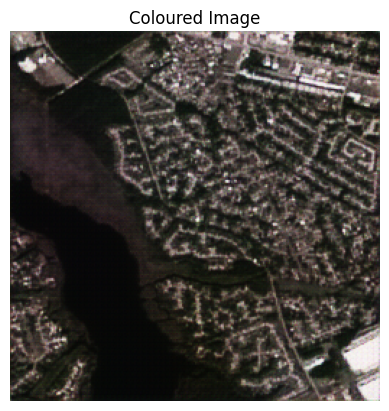

'\n# Save the colorized image\ncolorized_img.save(output_image_path)\nprint(f"Saved colorized image: {output_image_path}")\n'

In [34]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the U-Net generator (same as used in training)
class UNetGenerator(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, normalize=True):
            layers = [torch.nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
            if normalize:
                layers.append(torch.nn.BatchNorm2d(out_channels))
            layers.append(torch.nn.LeakyReLU(0.2))
            return torch.nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=0.0):
            layers = [torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                      torch.nn.BatchNorm2d(out_channels),
                      torch.nn.ReLU(inplace=True)]
            if dropout:
                layers.append(torch.nn.Dropout(dropout))
            return torch.nn.Sequential(*layers)

        self.down1 = down_block(in_channels, 64, normalize=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, normalize=False)

        self.up1 = up_block(512, 512, dropout=0.5)
        self.up2 = up_block(1024, 512, dropout=0.5)
        self.up3 = up_block(1024, 512, dropout=0.5)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return u8

# Load the trained generator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = UNetGenerator(in_channels=1, out_channels=3).to(device)
generator.load_state_dict(torch.load('generator_epoch.pth', map_location=device))

# Set the model to evaluation mode
generator.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale image
])

# Function to transform a single image
def transform_image(input_img_path):
    input_img = Image.open(input_img_path).convert('L')  # Convert to grayscale
    input_img = transform(input_img)
    input_img = input_img.unsqueeze(0).to(device)  # Add batch dimension

    # Generate the colorized image
    with torch.no_grad():
        fake_img = generator(input_img)
        fake_img = (fake_img * 0.5) + 0.5  # Rescale to [0, 1]
        fake_img = fake_img.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    # Convert to PIL Image
    fake_img = (fake_img * 255).astype("uint8")
    return Image.fromarray(fake_img)

# Specify input and output paths
input_image_path = '/media/target/demo5.png'  # Path to the input grayscale SAR image
#output_image_path = '/media/target/out.png'  # Path to save the colorized SAR image

# Transform the image
colorized_img = transform_image(input_image_path)

plt.imshow(colorized_img)
plt.axis('off')
plt.title('Coloured Image')
plt.show()
'''
# Save the colorized image
colorized_img.save(output_image_path)
print(f"Saved colorized image: {output_image_path}")
'''